In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sys
sys.path.append("../camp_scripts") # change accordingly
sns.set_context('notebook')

In [4]:
from june.demography.geography import Geography
from june.demography.demography import load_age_and_sex_generators_for_bins, Demography, Population
from june.paths import data_path
from june.infection_seed import InfectionSeed
from june.simulator import Simulator
from june.infection import InfectionSelector
from june.interaction import Interaction
from june.groups import Hospital, Hospitals
from june.distributors import HospitalDistributor
from june.hdf5_savers import generate_world_from_hdf5
from june.groups import Cemeteries
from june.policy import Policy, Policies
from june.logger.read_logger import ReadLogger

from camps.paths import camp_data_path
from camps.world import World
from camps.groups.leisure import generate_leisure_for_world, generate_leisure_for_config
from camp_creation import generate_empty_world, populate_world, distribute_people_to_households # this is loaded from the ../camp_scripts folder

No --data argument given - defaulting to:
/home/florpi/camps/JUNE/data
No --configs argument given - defaulting to:
/home/florpi/camps/JUNE/configs


2020-09-01 16:57:42,277 - camps.paths - WARNING - No --data argument given - defaulting to:
/home/florpi/camps/JUNE/data
2020-09-01 16:57:42,278 - camps.paths - WARNING - No --configs argument given - defaulting to:
/home/florpi/camps/JUNE/configs
2020-09-01 16:57:42,279 - camps.paths - WARNING - No --camp_data argument given - defaulting to:
/home/florpi/camps/JUNE/camp_data
2020-09-01 16:57:42,281 - camps.paths - WARNING - No --configs_camps argument given - defaulting to:
/home/florpi/camps/JUNE/configs_camps


In [5]:
from camps.groups import PumpLatrines, PumpLatrineDistributor
from camps.groups import DistributionCenters, DistributionCenterDistributor
from camps.groups import Communals, CommunalDistributor
from camps.groups import FemaleCommunals, FemaleCommunalDistributor
from camps.groups import Religiouss, ReligiousDistributor
from camps.groups import Shelter, Shelters, ShelterDistributor
from camps.groups import IsolationUnit, IsolationUnits
from june.groups.leisure import HouseholdVisitsDistributor
from camps.groups import PlayGroups, PlayGroupDistributor

## Initialize the world

In [6]:
# create empty world's geography
world = generate_empty_world(filter_key = {"region" : ["CXB-219"]})

2020-09-01 16:57:42,510 - june.demography.geography - INFO - There are 65 areas and 4 super_areas in the world.


In [7]:
# populate empty world
populate_world(world)

In [8]:
# distribute people to households
distribute_people_to_households(world)

In [9]:
# this is not working
hospitals= Hospitals.from_file(
    filename=camp_data_path / 'input/hospitals/hospitals.csv'
)
world.hospitals = hospitals
for hospital in world.hospitals:
    hospital.super_area = world.super_areas.members[0]
hospital_distributor = HospitalDistributor(hospitals, 
                                           medic_min_age=20,
                                           patients_per_medic=10)

hospital_distributor.distribute_medics_from_world(world.people)
world.isolation_units = IsolationUnits([IsolationUnit()])

2020-09-01 16:57:43,203 - june.groups.hospital - INFO - There are 8 hospitals in the world.


In [10]:
world.pump_latrines = PumpLatrines.for_areas(world.areas)
world.distribution_centers = DistributionCenters.for_areas(world.areas)
world.communals = Communals.for_areas(world.areas)
world.female_communals = FemaleCommunals.for_areas(world.areas)
world.religiouss = Religiouss.for_areas(world.areas)
world.play_groups = PlayGroups.for_areas(world.areas)

In [11]:
#world.box_mode = False
world.cemeteries = Cemeteries()

## Geography exploration

### UNHCR camp blocks inside the World

In [12]:
super_areas = []
for super_area in world.super_areas:
    super_areas.append(super_area.name)

In [13]:
super_areas[:5]

['CXB-219-A', 'CXB-219-B', 'CXB-219-C', 'CXB-219-D']

### Mahjee blocks inside World

In [14]:
areas = []
for area in world.areas:
    areas.append(area.name)

In [15]:
areas[:5]

['CXB-219-062', 'CXB-219-063', 'CXB-219-061', 'CXB-219-060', 'CXB-219-065']

## Demography exploration

### UNHCR block residents

In [16]:
sample_ages = []
sample_sexes = []
for person in world.super_areas.members[0].people:
    sample_ages.append(person.age)
    sample_sexes.append(person.sex)

In [17]:
sample_sexes[:5], sample_ages[:5]

(['m', 'm', 'f', 'f', 'f'], [39, 48, 44, 35, 21])

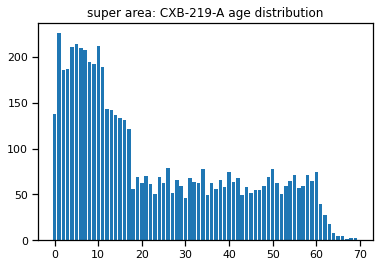

In [18]:
ages, counts = np.unique(sample_ages, return_counts=True)
plt.bar(ages, counts)
plt.title('super area: {} age distribution'.format(world.super_areas.members[0].name))
plt.show()

In [19]:
print ('The % children between ages 0-16 is {}%'.format(round(np.sum(counts[:16])/(np.sum(counts[:16])+np.sum(counts[16:]))*100)))

The % children between ages 0-16 is 49.0%


## Households

### Household size distribution

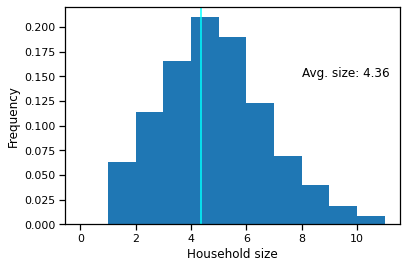

In [20]:
household_sizes = [household.size for household in world.households]
plt.hist(household_sizes, density=True, bins=np.arange(0,12))
plt.xlabel("Household size")
plt.ylabel("Frequency")
plt.axvline(np.mean(household_sizes), color="cyan")
plt.text(8, 0.150, f"Avg. size: {(np.mean(household_sizes)):.2f}")
plt.show()

# Shelters

In [21]:
world.shelters = Shelters.for_areas(world.areas)
shelter_distributor = ShelterDistributor(sharing_shelter_ratio = 0.75) # proportion of families that share a shelter
for area in world.areas:
    shelter_distributor.distribute_people_in_shelters(area.shelters, area.households)

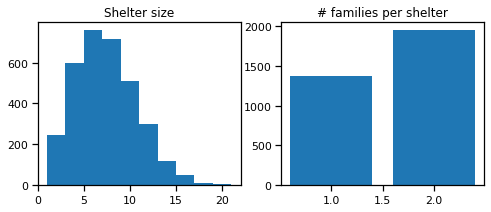

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
shelter_sizes = [shelter.size for shelter in world.shelters]
shelter_families = [shelter.n_families for shelter in world.shelters]
ax[0].hist(shelter_sizes)
ax[0].set_title("Shelter size")
shelter_families = {1 : len([shelter for shelter in world.shelters if shelter.n_families == 1]),
                    2 : len([shelter for shelter in world.shelters if shelter.n_families == 2])}
ax[1].bar(shelter_families.keys(), shelter_families.values())
ax[1].set_title("# families per shelter")
plt.show()

## Activity exploration

### Pumps and latrines 

In [23]:
pumps_and_latrines = []
for pump_latrine in world.areas.members[0].pump_latrines:
    pumps_and_latrines.append(pump_latrine)

In [24]:
print ('There are {} pumps and latrines in area {}'.format(len(pumps_and_latrines), world.areas.members[0].name))

There are 3 pumps and latrines in area CXB-219-062


### Distribution centers

In [25]:
distribution_centers = []
for center in world.distribution_centers:
    distribution_centers.append(center)

In [26]:
distribution_centers[0].coordinates

array([21.1962 , 92.14936])

### Communal spaces

In [27]:
communal_spaces = []
for space in world.communals:
    communal_spaces.append(space)

In [28]:
communal_spaces[0].coordinates

array([21.19621, 92.14924])

### Female friendly communal spaces

In [29]:
female_communal_spaces = []
for space in world.female_communals:
    female_communal_spaces.append(space)

In [30]:
female_communal_spaces[0].coordinates

array([21.19588, 92.152  ])

### Religious sites

In [31]:
religious = []
for rel in world.religiouss:
    religious.append(rel)

In [32]:
religious[0].coordinates

array([21.20069, 92.15216])

# Adding the infection

In [33]:
selector = InfectionSelector.from_file()

# Adding the interaction

In [34]:
interaction = Interaction.from_file(config_filename='../configs_camps/defaults/interaction/ContactInteraction.yaml')

# Set policies

In [35]:
policies = Policies.from_file('../configs_camps/defaults/policy/policy.yaml', base_policy_modules=('june.policy', 'camps.policy'))

In [36]:
policies.policies

# Seed the disease

In [37]:
seed = InfectionSeed(world.super_areas,
           selector)

seed.unleash_virus(n_cases=5)

# Init leisure

In [38]:
CONFIG_PATH = "../configs_camps/config_example.yaml"

leisure_instance = generate_leisure_for_config(
            world=world, config_filename=CONFIG_PATH
)
leisure_instance.leisure_distributors = {}
leisure_instance.leisure_distributors['pump_latrines'] = PumpLatrineDistributor.from_config(pump_latrines=world.pump_latrines)
leisure_instance.leisure_distributors['distribution_centers'] = DistributionCenterDistributor.from_config(distribution_centers=world.distribution_centers)
leisure_instance.leisure_distributors['communals'] = CommunalDistributor.from_config(communals=world.communals)
leisure_instance.leisure_distributors['female_communals'] = FemaleCommunalDistributor.from_config(female_communals=world.female_communals)
leisure_instance.leisure_distributors['play_groups'] = PlayGroupDistributor.from_config(play_groups=world.play_groups)

#associate social activities to shelters
leisure_instance.distribute_social_venues_to_households(world.shelters, world.super_areas)
leisure_instance.leisure_distributors

2020-09-01 16:57:45,491 - june.groups.leisure.leisure - INFO - Distributing social venues to households
2020-09-01 16:57:45,492 - june.groups.leisure.leisure - INFO - Distributed in 0 of 3312 households.


{'pump_latrines': <camps.groups.pump_latrine.PumpLatrineDistributor at 0x7f43ac37f1f0>,
 'distribution_centers': <camps.groups.distribution_center.DistributionCenterDistributor at 0x7f43ac37f2b0>,
 'communals': <camps.groups.communal.CommunalDistributor at 0x7f43ac37f100>,
 'female_communals': <camps.groups.female_communal.FemaleCommunalDistributor at 0x7f43ac37f6d0>,
 'play_groups': <camps.groups.play_group.PlayGroupDistributor at 0x7f43ac37f5e0>}

# Initialize simulator and run

In [39]:
simulator = Simulator.from_file(
    world = world,
    interaction = interaction,
    infection_selector=selector,
    leisure = leisure_instance,
    policies=policies,
    config_filename = CONFIG_PATH
)

In [40]:
%%time
simulator.run()

2020-09-01 16:57:47,402 - june.simulator - INFO - Starting group_dynamics for 120 days at day 0
2020-09-01 16:57:47,403 - june.simulator - INFO - starting the loop ..., at 0 days, to run for 120 days
2020-09-01 16:57:47,569 - june.simulator - INFO - Date = 2020-05-24 00:00:00, number of deaths =  0, number of infected = 5
2020-09-01 16:57:48,199 - june.simulator - INFO - Date = 2020-05-24 03:00:00, number of deaths =  0, number of infected = 5
2020-09-01 16:57:48,470 - june.simulator - INFO - Date = 2020-05-24 05:00:00, number of deaths =  0, number of infected = 5
2020-09-01 16:57:48,733 - june.simulator - INFO - Date = 2020-05-24 07:00:00, number of deaths =  0, number of infected = 5
2020-09-01 16:57:48,982 - june.simulator - INFO - Date = 2020-05-24 09:00:00, number of deaths =  0, number of infected = 5
2020-09-01 16:57:49,127 - june.simulator - INFO - Date = 2020-05-24 11:00:00, number of deaths =  0, number of infected = 5
2020-09-01 16:57:49,271 - june.simulator - INFO - Date =

2020-09-01 16:58:04,552 - june.simulator - INFO - Date = 2020-06-03 10:00:00, number of deaths =  0, number of infected = 144
2020-09-01 16:58:04,694 - june.simulator - INFO - Date = 2020-06-04 00:00:00, number of deaths =  0, number of infected = 170
2020-09-01 16:58:04,946 - june.simulator - INFO - Date = 2020-06-04 02:00:00, number of deaths =  0, number of infected = 174
2020-09-01 16:58:05,185 - june.simulator - INFO - Date = 2020-06-04 04:00:00, number of deaths =  0, number of infected = 179
2020-09-01 16:58:05,419 - june.simulator - INFO - Date = 2020-06-04 06:00:00, number of deaths =  0, number of infected = 184
2020-09-01 16:58:05,657 - june.simulator - INFO - Date = 2020-06-04 08:00:00, number of deaths =  0, number of infected = 196
2020-09-01 16:58:05,799 - june.simulator - INFO - Date = 2020-06-04 10:00:00, number of deaths =  0, number of infected = 211
2020-09-01 16:58:05,942 - june.simulator - INFO - Date = 2020-06-05 00:00:00, number of deaths =  0, number of infecte

2020-09-01 16:58:22,576 - june.simulator - INFO - Date = 2020-06-14 09:00:00, number of deaths =  0, number of infected = 5798
2020-09-01 16:58:22,909 - june.simulator - INFO - Date = 2020-06-14 11:00:00, number of deaths =  0, number of infected = 6049
2020-09-01 16:58:23,376 - june.simulator - INFO - Date = 2020-06-15 00:00:00, number of deaths =  0, number of infected = 6756
2020-09-01 16:58:23,805 - june.simulator - INFO - Date = 2020-06-15 02:00:00, number of deaths =  0, number of infected = 6911
2020-09-01 16:58:24,282 - june.simulator - INFO - Date = 2020-06-15 04:00:00, number of deaths =  0, number of infected = 7173
2020-09-01 16:58:24,733 - june.simulator - INFO - Date = 2020-06-15 06:00:00, number of deaths =  0, number of infected = 7416
2020-09-01 16:58:25,156 - june.simulator - INFO - Date = 2020-06-15 08:00:00, number of deaths =  0, number of infected = 7655
2020-09-01 16:58:25,490 - june.simulator - INFO - Date = 2020-06-15 10:00:00, number of deaths =  0, number of 

2020-09-01 16:59:02,638 - june.simulator - INFO - Date = 2020-06-25 06:00:00, number of deaths =  3, number of infected = 22114
2020-09-01 16:59:03,209 - june.simulator - INFO - Date = 2020-06-25 08:00:00, number of deaths =  3, number of infected = 22129
2020-09-01 16:59:03,800 - june.simulator - INFO - Date = 2020-06-25 10:00:00, number of deaths =  3, number of infected = 22147
2020-09-01 16:59:04,297 - june.simulator - INFO - Date = 2020-06-26 00:00:00, number of deaths =  3, number of infected = 22175
2020-09-01 16:59:04,854 - june.simulator - INFO - Date = 2020-06-26 02:00:00, number of deaths =  4, number of infected = 22175
2020-09-01 16:59:05,420 - june.simulator - INFO - Date = 2020-06-26 04:00:00, number of deaths =  4, number of infected = 22181
2020-09-01 16:59:05,991 - june.simulator - INFO - Date = 2020-06-26 06:00:00, number of deaths =  4, number of infected = 22197
2020-09-01 16:59:06,555 - june.simulator - INFO - Date = 2020-06-26 08:00:00, number of deaths =  4, num

2020-09-01 16:59:38,251 - june.simulator - INFO - Date = 2020-07-06 02:00:00, number of deaths =  12, number of infected = 17072
2020-09-01 16:59:38,801 - june.simulator - INFO - Date = 2020-07-06 04:00:00, number of deaths =  12, number of infected = 16981
2020-09-01 16:59:39,363 - june.simulator - INFO - Date = 2020-07-06 06:00:00, number of deaths =  12, number of infected = 16863
2020-09-01 16:59:39,978 - june.simulator - INFO - Date = 2020-07-06 08:00:00, number of deaths =  12, number of infected = 16749
2020-09-01 16:59:40,458 - june.simulator - INFO - Date = 2020-07-06 10:00:00, number of deaths =  12, number of infected = 16648
2020-09-01 16:59:40,898 - june.simulator - INFO - Date = 2020-07-07 00:00:00, number of deaths =  12, number of infected = 15841
2020-09-01 16:59:41,444 - june.simulator - INFO - Date = 2020-07-07 02:00:00, number of deaths =  12, number of infected = 15733
2020-09-01 16:59:41,982 - june.simulator - INFO - Date = 2020-07-07 04:00:00, number of deaths = 

2020-09-01 17:00:05,006 - june.simulator - INFO - Date = 2020-07-16 10:00:00, number of deaths =  16, number of infected = 2925
2020-09-01 17:00:05,207 - june.simulator - INFO - Date = 2020-07-17 00:00:00, number of deaths =  17, number of infected = 2497
2020-09-01 17:00:05,518 - june.simulator - INFO - Date = 2020-07-17 02:00:00, number of deaths =  17, number of infected = 2438
2020-09-01 17:00:05,840 - june.simulator - INFO - Date = 2020-07-17 04:00:00, number of deaths =  17, number of infected = 2375
2020-09-01 17:00:06,150 - june.simulator - INFO - Date = 2020-07-17 06:00:00, number of deaths =  17, number of infected = 2308
2020-09-01 17:00:06,449 - june.simulator - INFO - Date = 2020-07-17 08:00:00, number of deaths =  17, number of infected = 2258
2020-09-01 17:00:06,649 - june.simulator - INFO - Date = 2020-07-17 10:00:00, number of deaths =  17, number of infected = 2185
2020-09-01 17:00:06,839 - june.simulator - INFO - Date = 2020-07-18 00:00:00, number of deaths =  17, nu

2020-09-01 17:00:21,283 - june.simulator - INFO - Date = 2020-07-27 08:00:00, number of deaths =  19, number of infected = 154
2020-09-01 17:00:21,433 - june.simulator - INFO - Date = 2020-07-27 10:00:00, number of deaths =  19, number of infected = 152
2020-09-01 17:00:21,562 - june.simulator - INFO - Date = 2020-07-28 00:00:00, number of deaths =  19, number of infected = 136
2020-09-01 17:00:21,787 - june.simulator - INFO - Date = 2020-07-28 02:00:00, number of deaths =  19, number of infected = 133
2020-09-01 17:00:22,030 - june.simulator - INFO - Date = 2020-07-28 04:00:00, number of deaths =  19, number of infected = 131
2020-09-01 17:00:22,265 - june.simulator - INFO - Date = 2020-07-28 06:00:00, number of deaths =  19, number of infected = 128
2020-09-01 17:00:22,497 - june.simulator - INFO - Date = 2020-07-28 08:00:00, number of deaths =  19, number of infected = 124
2020-09-01 17:00:22,627 - june.simulator - INFO - Date = 2020-07-28 10:00:00, number of deaths =  19, number of

2020-09-01 17:00:35,794 - june.simulator - INFO - Date = 2020-08-07 06:00:00, number of deaths =  19, number of infected = 37
2020-09-01 17:00:36,059 - june.simulator - INFO - Date = 2020-08-07 08:00:00, number of deaths =  19, number of infected = 37
2020-09-01 17:00:36,203 - june.simulator - INFO - Date = 2020-08-07 10:00:00, number of deaths =  19, number of infected = 37
2020-09-01 17:00:36,344 - june.simulator - INFO - Date = 2020-08-08 00:00:00, number of deaths =  20, number of infected = 34
2020-09-01 17:00:36,670 - june.simulator - INFO - Date = 2020-08-08 03:00:00, number of deaths =  20, number of infected = 33
2020-09-01 17:00:37,028 - june.simulator - INFO - Date = 2020-08-08 05:00:00, number of deaths =  20, number of infected = 33
2020-09-01 17:00:37,334 - june.simulator - INFO - Date = 2020-08-08 07:00:00, number of deaths =  20, number of infected = 33
2020-09-01 17:00:37,667 - june.simulator - INFO - Date = 2020-08-08 09:00:00, number of deaths =  20, number of infect

2020-09-01 17:00:52,697 - june.simulator - INFO - Date = 2020-08-18 06:00:00, number of deaths =  20, number of infected = 11
2020-09-01 17:00:53,021 - june.simulator - INFO - Date = 2020-08-18 08:00:00, number of deaths =  20, number of infected = 11
2020-09-01 17:00:53,193 - june.simulator - INFO - Date = 2020-08-18 10:00:00, number of deaths =  20, number of infected = 11
2020-09-01 17:00:53,363 - june.simulator - INFO - Date = 2020-08-19 00:00:00, number of deaths =  20, number of infected = 9
2020-09-01 17:00:53,644 - june.simulator - INFO - Date = 2020-08-19 02:00:00, number of deaths =  20, number of infected = 9
2020-09-01 17:00:53,926 - june.simulator - INFO - Date = 2020-08-19 04:00:00, number of deaths =  20, number of infected = 9
2020-09-01 17:00:54,207 - june.simulator - INFO - Date = 2020-08-19 06:00:00, number of deaths =  20, number of infected = 9
2020-09-01 17:00:54,582 - june.simulator - INFO - Date = 2020-08-19 08:00:00, number of deaths =  20, number of infected =

2020-09-01 17:01:12,460 - june.simulator - INFO - Date = 2020-08-29 07:00:00, number of deaths =  20, number of infected = 5
2020-09-01 17:01:12,764 - june.simulator - INFO - Date = 2020-08-29 09:00:00, number of deaths =  20, number of infected = 5
2020-09-01 17:01:12,923 - june.simulator - INFO - Date = 2020-08-29 11:00:00, number of deaths =  20, number of infected = 5
2020-09-01 17:01:13,064 - june.simulator - INFO - Date = 2020-08-30 00:00:00, number of deaths =  20, number of infected = 5
2020-09-01 17:01:13,337 - june.simulator - INFO - Date = 2020-08-30 03:00:00, number of deaths =  20, number of infected = 5
2020-09-01 17:01:13,602 - june.simulator - INFO - Date = 2020-08-30 05:00:00, number of deaths =  20, number of infected = 5
2020-09-01 17:01:13,871 - june.simulator - INFO - Date = 2020-08-30 07:00:00, number of deaths =  20, number of infected = 5
2020-09-01 17:01:14,160 - june.simulator - INFO - Date = 2020-08-30 09:00:00, number of deaths =  20, number of infected = 5


2020-09-01 17:01:27,548 - june.simulator - INFO - Date = 2020-09-09 06:00:00, number of deaths =  20, number of infected = 3
2020-09-01 17:01:27,802 - june.simulator - INFO - Date = 2020-09-09 08:00:00, number of deaths =  20, number of infected = 3
2020-09-01 17:01:27,947 - june.simulator - INFO - Date = 2020-09-09 10:00:00, number of deaths =  20, number of infected = 3
2020-09-01 17:01:28,099 - june.simulator - INFO - Date = 2020-09-10 00:00:00, number of deaths =  20, number of infected = 3
2020-09-01 17:01:28,360 - june.simulator - INFO - Date = 2020-09-10 02:00:00, number of deaths =  20, number of infected = 3
2020-09-01 17:01:28,633 - june.simulator - INFO - Date = 2020-09-10 04:00:00, number of deaths =  20, number of infected = 3
2020-09-01 17:01:28,920 - june.simulator - INFO - Date = 2020-09-10 06:00:00, number of deaths =  20, number of infected = 3
2020-09-01 17:01:29,202 - june.simulator - INFO - Date = 2020-09-10 08:00:00, number of deaths =  20, number of infected = 3


2020-09-01 17:01:42,450 - june.simulator - INFO - Date = 2020-09-20 07:00:00, number of deaths =  20, number of infected = 1
2020-09-01 17:01:42,716 - june.simulator - INFO - Date = 2020-09-20 09:00:00, number of deaths =  20, number of infected = 1
2020-09-01 17:01:42,866 - june.simulator - INFO - Date = 2020-09-20 11:00:00, number of deaths =  20, number of infected = 1
CPU times: user 3min 54s, sys: 4.42 s, total: 3min 58s
Wall time: 3min 55s


# Getting the results

All results are stored in a json file specified in the ``save_path`` variable in the config file. We can also access it from ``world.logger`` directly.

In [56]:
import pandas as pd
read = ReadLogger()

In [42]:
read.load_infection_location()

In [43]:
infection_locations = read.get_locations_infections()

In [44]:
unique_locations, counts_locations = np.unique(
                np.array(infection_locations),
                return_counts=True)

location_counts_df = pd.DataFrame(
    {'locations': unique_locations,
    'counts': counts_locations}
)
location_counts_df.set_index('locations', inplace=True)


In [45]:
location_counts_df['percent_infections']= 100*(location_counts_df['counts'])/location_counts_df.values.sum()

Text(0.5, 0, 'location')

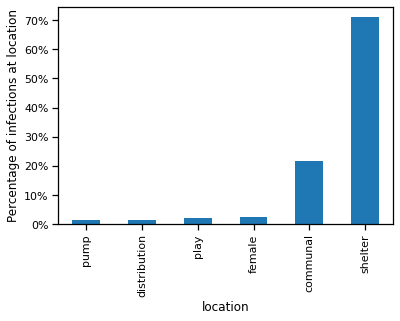

In [46]:
import matplotlib.ticker as mtick

ax = location_counts_df['percent_infections'].sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')

In [47]:
for location in unique_locations:
    read.locations_df[str(location)] = read.locations_df.apply(
        lambda x: x.location.count(str(location)), axis=1
    )
read.locations_df.index = pd.to_datetime(read.locations_df.index)

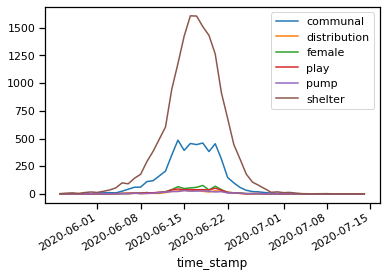

In [48]:
read.locations_df.iloc[:,3:].plot()

# Where did outbreaks happen?

In [49]:
unique_id, count_id =  np.unique(
        np.array(read.locations_df['location_id'].sum()),
        return_counts=True
)

In [50]:
unique_id[np.argsort(count_id)[-5:]]

array(['communal_97', 'communal_59', 'communal_17', 'communal_80',
       'communal_94'], dtype='<U22')

In [51]:
count_id[np.argsort(count_id)[-5:]]

array([56, 61, 61, 64, 66])

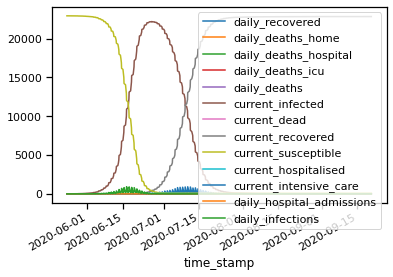

In [52]:
world_df = read.world_summary()
world_df.plot()
#plt.axvspan(policies.social_distancing_start, 
#            policies.social_distancing_end,
#            facecolor='y', alpha=0.2)
plt.legend()

# Output to save

In [62]:
sa_summary = read.super_area_summary()

In [64]:
sa_summary['super_area'].unique()

array(['CXB-219-A', 'CXB-219-B', 'CXB-219-C', 'CXB-219-D'], dtype=object)

In [71]:
super_area_region = pd.read_csv(camp_data_path 
    / 'input/geography/area_super_area_region.csv')
super_area_region = super_area_region.drop(columns="area").drop_duplicates()
super_area_region.set_index("super_area", inplace=True)

In [72]:
super_area_region

,Unnamed: 0,region
super_area,,
CXB-219-C,0,CXB-219
CXB-219-C,1,CXB-219
CXB-219-C,2,CXB-219
CXB-219-C,3,CXB-219
CXB-219-C,4,CXB-219
...,...,...
CXB-216-A,1380,CXB-216
CXB-232-B,1381,CXB-232
CXB-232-C,1382,CXB-232


In [74]:
summary = read.run_summary(
    super_area_region_path=camp_data_path 
    / 'input/geography/area_super_area_region.csv'
)

In [75]:
summary

,super_area,current_infected,current_dead,current_recovered,current_susceptible,current_hospitalised,current_intensive_care,daily_recovered,daily_deaths_home,daily_deaths_hospital,daily_deaths_icu,daily_deaths,daily_hospital_admissions,daily_infections,region,location_id
time_stamp,,,,,,,,,,,,,,,,
2020-05-29,CXB-219-A,0,0,0,5968,0,0,0,0,0,0,0,0.0,1,CXB-219,[communal_33]
2020-06-01,CXB-219-A,1,0,0,5967,0,0,0,0,0,0,0,0.0,1,CXB-219,[communal_65]
2020-06-02,CXB-219-A,3,0,0,5965,0,0,0,0,0,0,0,0.0,4,CXB-219,"[communal_121, communal_91, communal_91, shelt..."
2020-06-03,CXB-219-A,8,0,0,5960,0,0,0,0,0,0,0,0.0,9,CXB-219,"[distribution_center_14, communal_40, shelter_..."
2020-06-04,CXB-219-A,20,0,0,5948,0,0,0,0,0,0,0,0.0,13,CXB-219,"[shelter_519, shelter_802, communal_29, commun..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-01,CXB-219-D,4367,2,399,24,10,1,114,0,0,0,0,2.0,4,CXB-219,"[communal_97, shelter_3303, communal_67, shelt..."
2020-07-02,CXB-219-D,4248,3,521,20,7,1,134,0,1,1,2,0.0,6,CXB-219,"[shelter_2697, shelter_3041, shelter_3041, she..."
2020-07-04,CXB-219-D,3928,4,845,15,7,1,192,0,0,0,0,3.0,2,CXB-219,"[play_group_292, shelter_2697]"
